In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# Data Reading

In [2]:
df = pd.read_csv('/kaggle/input/energyconsumption/energy_consumption.csv')
df.head()

,Datetime,DOM_MW
0,2005-12-31 01:00:00,9389.0
1,2005-12-31 02:00:00,9070.0
2,2005-12-31 03:00:00,9001.0
3,2005-12-31 04:00:00,9042.0
4,2005-12-31 05:00:00,9132.0


In [3]:
df.tail()

,Datetime,DOM_MW
116184,2018-01-01 20:00:00,18418.0
116185,2018-01-01 21:00:00,18567.0
116186,2018-01-01 22:00:00,18307.0
116187,2018-01-01 23:00:00,17814.0
116188,2018-01-02 00:00:00,17428.0


# Data Preprocessing

## Split data into train and test

In [4]:
train_size = int(len(df) * 0.80)
train_data = df[:train_size]
print(f'training size:  {len(train_data)}')
train_data.tail()

training size:  92951


,Datetime,DOM_MW
92946,2015-01-24 13:00:00,12887.0
92947,2015-01-24 14:00:00,12674.0
92948,2015-01-24 15:00:00,12379.0
92949,2015-01-24 16:00:00,12057.0
92950,2015-01-24 17:00:00,11911.0


In [5]:
test_data = df[train_size:]
print(f'testing size:  {len(test_data)}')
test_data.tail()

testing size:  23238


,Datetime,DOM_MW
116184,2018-01-01 20:00:00,18418.0
116185,2018-01-01 21:00:00,18567.0
116186,2018-01-01 22:00:00,18307.0
116187,2018-01-01 23:00:00,17814.0
116188,2018-01-02 00:00:00,17428.0


> Select DOM_MW column from train and test data

In [6]:
train_array = train_data.loc[:, ['DOM_MW']].values
test_array = test_data.loc[:, ['DOM_MW']].values

In [7]:
train_array

array([[ 9389.],
       [ 9070.],
       [ 9001.],
       ...,
       [12379.],
       [12057.],
       [11911.]])

## Scaling the data

In [8]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_array)

In [9]:
time_step = 30
X_train = [] #Sequence of data
y_train = [] #target value (next time step)

for i in range(time_step, len(train_scaled)):
    X_train.append(train_scaled[i - time_step : i , 0])
    y_train.append(train_scaled[i,0])


In [10]:
#Return X_train and y_train as NumPy Arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

In [11]:
print(X_train.shape)
print(y_train.shape)

(92921, 30)
(92921,)


In [12]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(92921, 30, 1)

# Build RNN Model

In [26]:
#Build RNN Model
RNN_Model = Sequential([
    #Input SimpleRNN layer
    SimpleRNN(200,activation = 'tanh', return_sequences = True, input_shape = (30,1)),
    
    SimpleRNN(200, return_sequences=True),
    
    Dropout(0.2),
    SimpleRNN(100, return_sequences=True),

    Dropout(0.2),
    SimpleRNN(50, return_sequences=True),

    SimpleRNN(50),

    Dense(1)
    
])

In [28]:
RNN_Model.compile(optimizer = tf.keras.optimizers.Adam(),
                 loss = tf.keras.losses.mse)

In [29]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor = 'loss',
    patience = 5,
    restore_best_weights = True 
)

In [30]:
RNN_Model.fit(X_train, y_train,callbacks = [early_stopping], epochs = 20)

Epoch 1/20
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 53s 15ms/step - loss: 0.0225
Epoch 2/20
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - loss: 0.0012
Epoch 3/20
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - loss: 6.4578e-04
Epoch 4/20
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0023
Epoch 5/20
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - loss: 0.0160
Epoch 6/20
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - loss: 0.0141
Epoch 7/20
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - loss: 0.0141
Epoch 8/20
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - loss: 0.0141


In [31]:
total_data = pd.concat((df['DOM_MW'], test_data['DOM_MW']), axis = 0)
inputs = total_data[len(total_data) - len(test_data) - time_step:].values.reshape(-1,1)
inputs.shape

(23268, 1)

In [32]:
inputs = scaler.transform(inputs)

In [33]:
X_test = []
for i in range(time_step, 23268 ):
    X_test.append(inputs[i- time_step:i - 0])

X_test = np.array(X_test)
X_test.shape

(23238, 30, 1)

## Prediction and Evaluation of the RNN Model

In [34]:
RNN_Prediction = RNN_Model.predict(X_test)

727/727 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


In [37]:
RNN_Prediction = scaler.inverse_transform(RNN_Prediction)

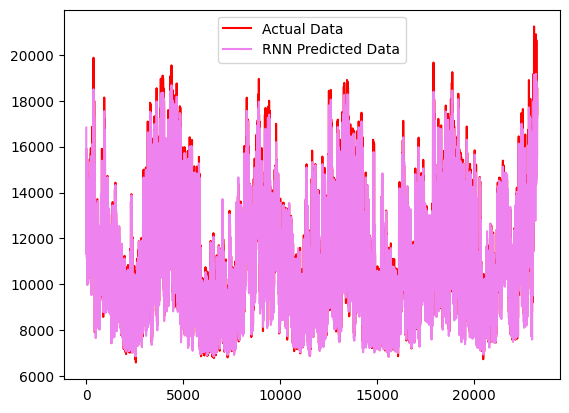

In [40]:
plt.plot(test_array, color = 'red', label = 'Actual Data')
plt.plot(RNN_Prediction, color = 'violet', label = 'RNN Predicted Data')
plt.legend()
plt.show()

# Build LSTM Model

In [41]:
#Build LSTM Model
LSTM_Model = Sequential([
    #Input SimpleRNN layer
    LSTM(200,activation = 'tanh', return_sequences = True, input_shape = (30,1)),
    
    LSTM(200, return_sequences=True),
    
    Dropout(0.2),
    LSTM(100, return_sequences=True),

    Dropout(0.2),
    LSTM(50, return_sequences=True),

    LSTM(50),

    Dense(1)
    
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [44]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor = 'loss',
    patience = 5,
    restore_best_weights = True 
)

In [42]:
LSTM_Model.compile(optimizer = tf.keras.optimizers.Adam(),
                 loss = tf.keras.losses.mse)

In [45]:
LSTM_Model.fit(X_train, y_train,callbacks = [early_stopping], epochs = 20)

Epoch 1/20
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - loss: 0.0050
Epoch 2/20
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - loss: 5.2885e-04
Epoch 3/20
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - loss: 3.7370e-04
Epoch 4/20
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - loss: 3.5859e-04
Epoch 5/20
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - loss: 3.1034e-04
Epoch 6/20
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - loss: 2.9781e-04
Epoch 7/20
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - loss: 2.6850e-04
Epoch 8/20
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - loss: 2.7035e-04
Epoch 9/20
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - loss: 2.4884e-04
Epoch 10/20
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - loss: 2.2848e-04
Epoch 11/20
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - loss: 2.2229e-04
Epoch 12/20
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - loss: 2.1581e-04
Epoch 13/20
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - loss: 1.8733e-04
Epoch 14/20
2904/2904 ━━━

## Prediction and Evaluation of the LSTM Model

In [46]:
LSTM_Prediction = LSTM_Model.predict(X_test)

727/727 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


In [47]:
LSTM_Prediction = scaler.inverse_transform(LSTM_Prediction)

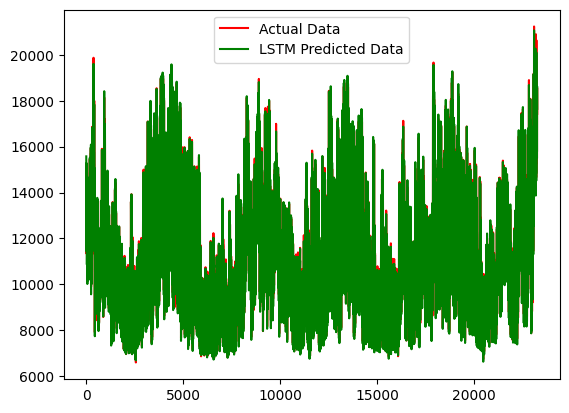

In [49]:
plt.plot(test_array, color ='red', label = 'Actual Data')
plt.plot(LSTM_Prediction, color ='green', label = 'LSTM Predicted Data')
plt.legend()
plt.show()

# Models Compare

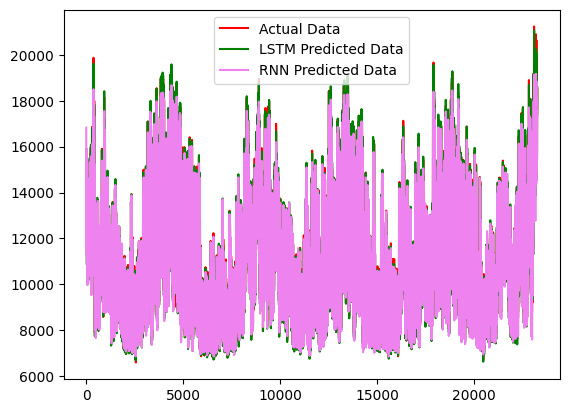

In [48]:
plt.plot(test_array, color ='red', label = 'Actual Data')
plt.plot(LSTM_Prediction, color ='green', label = 'LSTM Predicted Data')
plt.plot(RNN_Prediction, color ='violet', label = 'RNN Predicted Data')
plt.legend()
plt.show()